# Preprocessing Time Series Data

We will examine session 13 parquet file and see how preprocessing affects the data by examining the plots.

In [1]:
# import libs
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt

# import our own preprocessing function
from preprocess import ts_preprocess

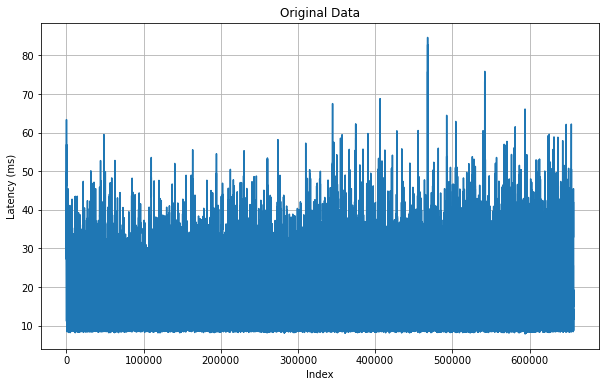

In [2]:
# Import the data (change filename to try processing other files)
pq_filename = "10-42-3-2_55500_20231113_141500.parquet"
df = pq.read_table(pq_filename).to_pandas()

# Calculate wall latency (timestamps.client.send.wall - timestamps.server.receive.wall)
wall_latency = pd.Series(data=(df['timestamps.server.receive.wall'] - df['timestamps.client.send.wall'])/1e6, index=df.index)
# Calculate monotonic latency (timestamps.client.send.monotonic - timestamps.server.receive.monotonic)
#monotonic_latency = pd.Series(data=(df['timestamps.server.receive.monotonic'] - df['timestamps.client.send.monotonic'])/1e6, index=df.index)

plt.figure(figsize=(10, 6))
plt.plot(wall_latency)
plt.title('Original Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

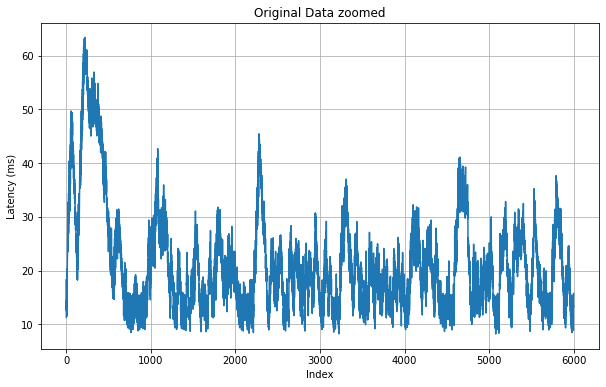

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(wall_latency[0:6000])
plt.title('Original Data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Data after denoising and removing outliers:

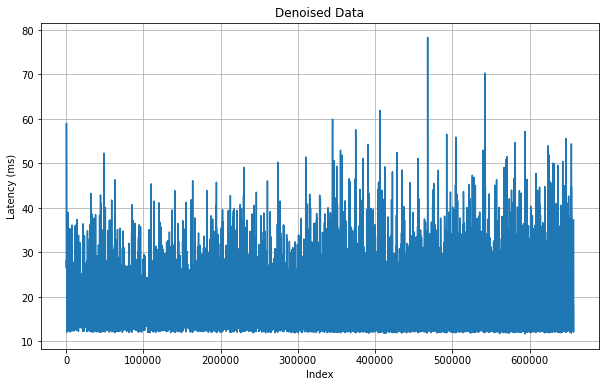

In [4]:
processed = ts_preprocess(wall_latency, window=50)

plt.figure(figsize=(10, 6))
plt.plot(processed)
plt.title('Denoised Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

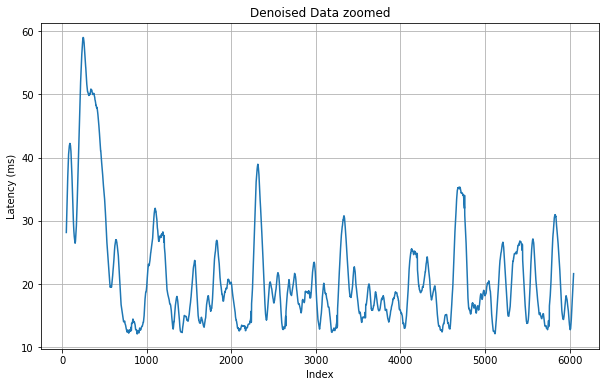

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(processed[0:6000])
plt.title('Denoised Data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### First-order difference for removing non-stationarity (recommended for traditional models):

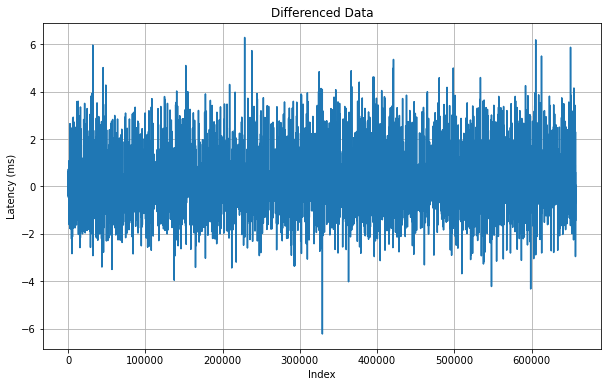

In [6]:
diff = ts_preprocess(wall_latency, window=50, diff=True)

plt.figure(figsize=(10, 6))
plt.plot(diff)
plt.title('Differenced Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

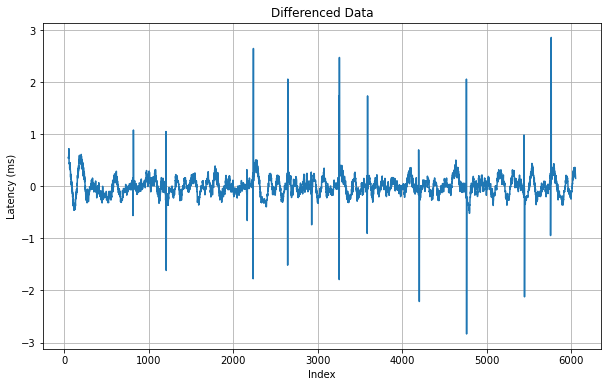

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(diff[0:6000])
plt.title('Differenced Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Normalization (can be used for Neural Networks):

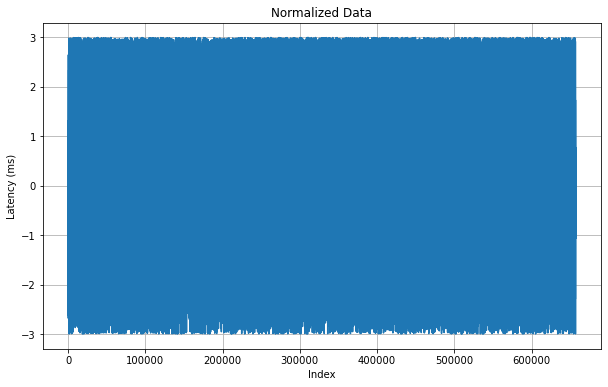

In [8]:
norm = ts_preprocess(wall_latency, window=50, normalize=True)

plt.figure(figsize=(10, 6))
plt.plot(norm)
plt.title('Normalized Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

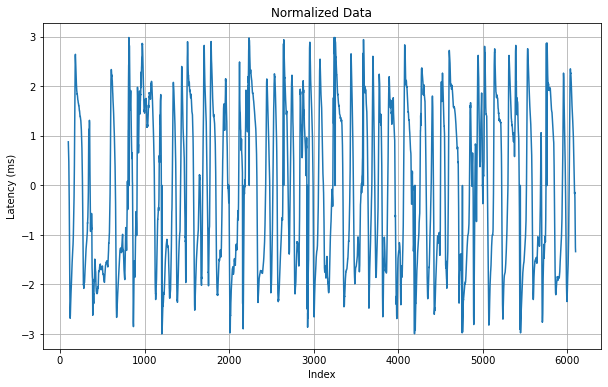

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(norm[0:6000])
plt.title('Normalized Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Difference and Normalization (not recommended):

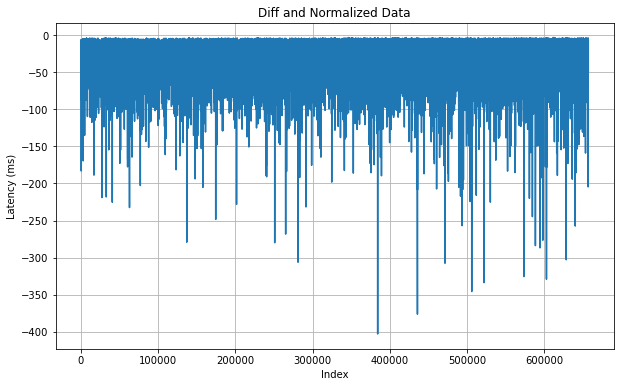

In [10]:
nd = ts_preprocess(wall_latency, window=50, diff=True, normalize=True)

plt.figure(figsize=(10, 6))
plt.plot(nd)
plt.title('Diff and Normalized Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Write to CSV:

In [11]:
processed.to_csv('denoised.csv')
diff.to_csv('differenced.csv')
norm.to_csv('normalized.csv')